## Kernel Rank and Spectrum Accuracy

The Intention of this notebook is to analyze the relationship between the rank of the kernel and the accuracy of the spectrum.

I start by importing things and setting up my experiment. I will compare the spectrum of this experiment with what I see coming out of the exact expression for the kernel. 

In [127]:
%load_ext autoreload
%autoreload 2
import torch
import sys
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')

from FCN3Network import FCN3NetworkEnsembleErf
from Experiment import Experiment

exp = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401',
        N=400,
        d=40,
        chi=50,
        P=250,
        ens=3,
        device = torch.device('cuda:1')
    )
exp.load()
exp.model.to(exp.device)
X, Y1,Y3 = exp.large_dataset(p_large = 3000, flat=True)
exp.model.device = exp.device
# compute the svd of the low rank approximaton to H
# Random svd goes from H ∈ ℝ^m*m to its low rank approximation QB ∈ ℝ^m*m with Q ∈ ℝ^m*l and B ∈ ℝ^l*k. 
Q, Z = exp.model.J_random_QB(X, k = 1600, p=10)
Ut, _S, V = torch.linalg.svd(Z.T)
m, n = Z.shape[1], Z.shape[0]
k = min(m, n)
Sigma = torch.zeros(m, n, device=Z.device, dtype=Z.dtype)
Sigma[:k, :k] = torch.diag(_S) 
U = torch.matmul(Q, Ut)
Y = Y3 / torch.norm(Y3, dim=0) 
hamburger = (torch.matmul(Y.t(), U) @ _S.diag() @ torch.matmul(U.T, Y)).diagonal() / torch.norm(Y, dim=0)/ X.shape[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401/model.pth
[Random Omega generation] 0.0001s
[  res chunk [0:3000]] 0.0005s
[res computation (chunks of 4096)] 0.0006s
[QR factorisation] 0.0017s
[  Z chunk [0:3000]] 0.0002s
[Z computation (chunks of 4096)] 0.0002s


In [10]:
svd_eigenvalues = Sigma.diagonal() / X.shape[0]


In [ ]:
import torch
import time

# === Configuration ===
n = 3000
k = 1600
p = 10
l = k + p
chunk_size = 2048
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# From your experiment
P = exp.P          # ambient dimension
d = exp.d          # intrinsic dimension
sigma_w = torch.eye(d, dtype=torch.float32, device=device) / d   # (d, d)

# Precompute Sigma_w as a linear operator — we'll apply it via matmul with projected features
# Assuming X = Z @ W or similar, but we generate raw x in R^P, then project?

# === Deterministic row generation ===
def generate_X_row(idx: int, seed_base: int = 42) -> torch.Tensor:
    generator = torch.Generator()
    generator.manual_seed(seed_base + idx)
    x = torch.randn(d, generator=generator)
    return x.to(device=device, dtype=torch.float32)

# === Correct matrix-free matvec for arcsin kernel ===
def matvec_multi(V: torch.Tensor, chunk_size: int = chunk_size) -> torch.Tensor:
    """
    Compute (K @ V) where K_ij = (2/π) arcsin( (x_i^T Sigma_w x_j) / sqrt( (1+2||Sigma_w^{1/2} x_i||^2)(1+2||Sigma_w^{1/2} x_j||^2) )
    V: (n, l)
    Returns: (n, l)
    """
    res = torch.zeros_like(V)

    # Precompute all x_j^T Sigma_w for the denominator (same for all i)
    # We'll compute || Sigma_w^{1/2} x_j ||^2 once per row j
    denom_sqrt = torch.zeros(n, device=device, dtype=torch.float32)

    print("Precomputing denominators (this requires one pass over all rows)...")
    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        rows = []
        for i in range(start, end):
            x = generate_X_row(i)
            rows.append(x)
        X_chunk = torch.stack(rows)  # (chunk, d)

        # Compute x^T Sigma_w x = || Sigma_w^{1/2} x ||^2
        XSigma = torch.matmul(X_chunk, sigma_w)           # (chunk, d)
        X2 = torch.sum(X_chunk * XSigma, dim=1)           # (chunk,)
        denom_sqrt[start:end] = torch.sqrt(1.0 + 2.0 * X2) # (chunk,)

    print("Precomputation done.")

    # Now main loop: for each chunk of i, compute k(i,j) @ V_j
    for start_i in range(0, n, chunk_size):
        end_i = min(start_i + chunk_size, n)
        chunk_size_i = end_i - start_i
        X_i_rows = []
        for i in range(start_i, end_i):
            x = generate_X_row(i)
            X_i_rows.append(x)
        X_i = torch.stack(X_i_rows)  # (chunk_i, d)

        # Compute X_i @ sigma_w  (we'll use this to compute dot products)
        X_i_Sigma = torch.matmul(X_i, sigma_w)  # (chunk_i, d)

        # Denominator part for i
        denom_i = torch.sqrt(1.0 + 2.0 * torch.sum(X_i * X_i_Sigma, dim=1)/d)  # (chunk_i,)

        # Now loop over j in chunks to compute sum_j k_ij V_j
        temp = torch.zeros(chunk_size_i, l, device=device, dtype=torch.float32)

        for start_j in range(0, n, chunk_size):
            end_j = min(start_j + chunk_size, n)
            X_j_rows = [generate_X_row(j) for j in range(start_j, end_j)]
            X_j = torch.stack(X_j_rows)  # (chunk_j, d)
            V_j = V[start_j:end_j]       # (chunk_j, l)

            # Compute x_i^T Sigma_w x_j efficiently
            dots = torch.matmul(X_i_Sigma, X_j.t())  # (chunk_i, chunk_j)

            # Denominator: outer product of sqrt(1 + 2 x^T Sigma x) for i and j
            denom_j = denom_sqrt[start_j:end_j]  # (chunk_j,)
            denom = denom_i.unsqueeze(1) * denom_j.unsqueeze(0)  # (chunk_i, chunk_j)

            arg = 2.0 * dots / denom
            k_ij = (2.0 / torch.pi) * torch.arcsin(torch.clamp(arg, -1.0, 1.0))  # (chunk_i, chunk_j)

            # Accumulate: k_ij @ V_j
            temp += torch.matmul(k_ij, V_j)  # (chunk_i, l)

        res[start_i:end_i] = temp

    return res


# === Run the randomized SVD ===
torch.manual_seed(123)
Omega = torch.randn(n, l, device=device, dtype=torch.float32)

print("Computing Y = K @ Omega (matrix-free, correct arcsin kernel)...")
start = time.time()
Y = matvec_multi(Omega)
print(f"Y time: {time.time() - start:.2f} s")

Q, _ = torch.linalg.qr(Y)

print("Computing Z = K @ Q...")
start = time.time()
Z = matvec_multi(Q)
print(f"Z time: {time.time() - start:.2f} s")

B = torch.matmul(Q.t(), Z)
evals = torch.linalg.eigvalsh(B)
sorted_evals, _ = torch.sort(evals, descending=True)
top_eigs = sorted_evals / n



Computing Y = K @ Omega (matrix-free, correct arcsin kernel)...
Precomputing denominators (this requires one pass over all rows)...
Precomputation done.
Y time: 7.21 s
Computing Z = K @ Q...
Precomputing denominators (this requires one pass over all rows)...
Precomputation done.
Z time: 7.05 s


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [158]:
torch.cat?

Docstring:
cat(tensors, dim=0, *, out=None) -> Tensor

Concatenates the given sequence of tensors in :attr:`tensors` in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be a 1-D empty tensor with size ``(0,)``.

:func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
and :func:`torch.chunk`.

:func:`torch.cat` can be best understood via examples.

.. seealso::

    :func:`torch.stack` concatenates the given sequence along a new dimension.

Args:
    tensors (sequence of Tensors): Non-empty tensors provided must have the same shape,
        except in the cat dimension.

    dim (int, optional): the dimension over which the tensors are concatenated

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> x = torch.randn(2, 3)
    >>> x
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497]])
    >>> torch.cat((x, x, x), 0)
    tensor([[ 0.6580, -1.0969, -0.4

In [ ]:
X, Y1,Y3 = exp.large_dataset(p_large = n, flat=True)
Y = torch.cat((Y1, Y3), dim = 1)
Y = Y / torch.norm(Y, dim=0)
Ut, _S, V = torch.linalg.svd(Z.T)
_S = _S.to(exp.device).to(torch.float64)
Ut = Ut.to(exp.device).to(torch.float64)
Q = Q.to(exp.device).to(torch.float64)
Y = Y.to(exp.device).to(torch.float64)
m, n = Z.shape[1], Z.shape[0]
k = min(m, n)
Sigma = torch.zeros(m, n, device=exp.device, dtype=Z.dtype)
Sigma[:k, :k] = torch.diag(_S).to(exp.device) 
U = torch.matmul(Q, Ut).to(exp.device).to(Y.dtype)
Y = Y3 / torch.norm(Y3, dim=0)
Y = Y.to(exp.device)
hamburger = (torch.matmul(Y.t(), U) @ _S.diag() @ torch.matmul(U.T, Y)).diagonal() / torch.norm(Y, dim=0)/ X.shape[0]
hamburger = hamburger.detach().cpu().numpy()

In [171]:
torch.cat((Y1, Y3), dim = 1).shape

torch.Size([3000, 80])

In [170]:
hamburger.shape

(40,)

In [95]:
theory = exp.eig_predictions()


In [68]:
eigval = torch.linalg.eigvalsh(J)
eigval, _ = eigval.sort(descending=True)
eigval_nngp = eigval[:500].detach().cpu() 

In [162]:
eigval_nngp = hamburger # top_eigs[40:].detach().cpu()
eigval_true = svd_eigenvalues.detach().cpu()
ks = torch.arange(eigval_nngp.shape[0])


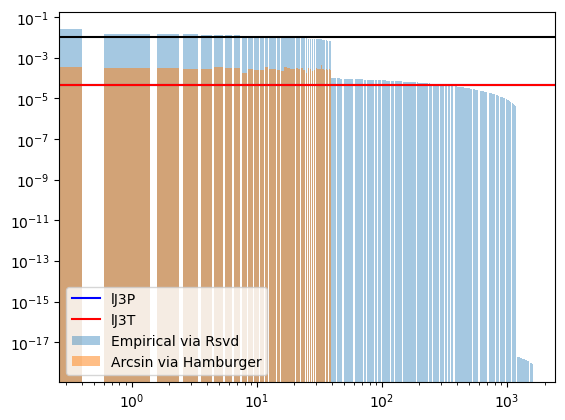

In [163]:
import matplotlib.pyplot as plt
plt.yscale('log')
plt.bar(torch.arange(eigval_true.shape[0]), eigval_true, label='Empirical via Rsvd',alpha=0.4)
plt.bar(torch.arange(eigval_nngp.shape[0]), eigval_nngp, alpha=0.5, label='Arcsin via Hamburger')
plt.xscale('log')
plt.axhline(y=theory.lJ3P, color='blue', label='lJ3P')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
plt.axhline(y=theory.lJ3T, color='red', label='lJ3T')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
plt.axhline(y=theory.lJ1P, color='black')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

plt.legend()

In [126]:
theory.lH1T, theory.lH1P

(0.045003022379059385, 0.010610329539460598)